<a href="https://colab.research.google.com/github/lokeshdonthi/AI-DRIVEN-FRAUD-DETECTION-AND-TRANSACTION-OPTIMIZATION-IN-PAYMENT-SYSTEMS/blob/main/SDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5dc31e7567a4eebd5261dd897774dc18d500e50489faf72cdcc45a78126ba1d9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import LIME for explainability
from lime import lime_tabular


In [ ]:
# 1) GLOBAL SETUP & SEED MANAGEMENT
###############################################################################
# Purpose: To ensure reproducibility and to help debug any variability across runs.

GLOBAL_SEED = 42

def set_all_seeds(seed=GLOBAL_SEED):
    print(f"[DEBUG] Setting all seeds to {seed} for reproducibility.")
    random.seed(seed)
    np.random.seed(seed)

set_all_seeds(GLOBAL_SEED)

# Log key library versions (debugging help)
import sys, platform
print(f"[DEBUG] Python version: {sys.version}")
print(f"[DEBUG] OS/Platform: {platform.platform()}")
print(f"[DEBUG] NumPy version: {np.__version__}")



[DEBUG] Setting all seeds to 42 for reproducibility.
[DEBUG] Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
[DEBUG] OS/Platform: Linux-6.1.123+-x86_64-with-glibc2.35
[DEBUG] NumPy version: 2.0.2


In [ ]:
###############################################################################
# 2) DATA LOADING & PREPROCESSING
###############################################################################
# Purpose: To load QR code images, resize them for consistency, and debug the total count.
import os
import cv2
import numpy as np
import warnings
from google.colab import drive

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Set Google Drive paths (Adjust if QR_Images is inside another folder)
drive_path = "/content/drive/My Drive/QR_Images"
benign_folder = os.path.join(drive_path, "benign_qr_images_500")
malicious_folder = os.path.join(drive_path, "malicious_qr_images_500")

# Verify if the folders exist
if not os.path.exists(benign_folder) or not os.path.exists(malicious_folder):
    print("[ERROR] One or both dataset folders are missing!")
    print("Check your Google Drive path and folder structure.")
else:
    print("[SUCCESS] Dataset folders found!")

# Function to load images
def load_images(folder, label, img_size=128):
    """
    Loads grayscale images from the given folder, resizes them to (img_size, img_size),
    and returns a list of tuples: (resized_image, label, filename).
    """
    data = []
    if not os.path.exists(folder):
        print(f"[ERROR] Folder not found: {folder}")
        return []

    files = os.listdir(folder)
    files.sort()  # Sort to ensure consistent order for debugging

    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"[WARNING] Could not load image: {path}")
            continue
        img_resized = cv2.resize(img, (img_size, img_size))
        data.append((img_resized, label, fname))

    return data

# Load benign and malicious images
benign_data = load_images(benign_folder, label=0)
mal_data = load_images(malicious_folder, label=1)
all_data = benign_data + mal_data

print(f"[DEBUG] Loaded {len(benign_data)} benign and {len(mal_data)} malicious images. Total = {len(all_data)}")


Mounted at /content/drive
[SUCCESS] Dataset folders found!
[DEBUG] Loaded 500 benign and 500 malicious images. Total = 1000


In [ ]:
###############################################################################
# 3) SIFT DESCRIPTOR EXTRACTION
###############################################################################
# Purpose: To extract robust local descriptors (SIFT) from each image.
sift = cv2.SIFT_create()
desc_list = []      # Will store a tuple (descriptors, morph_features, filename)
labels_list = []    # Stores the image label (0 or 1)
files_list = []     # Stores filenames for later reference

for (img, lbl, fname) in all_data:
    # Extract SIFT descriptors
    kp, desc = sift.detectAndCompute(img, None)
    if desc is None or len(desc) == 0:
        # If no keypoints found, create a dummy descriptor
        desc = np.zeros((1, 128), dtype=np.float32)
    # Append SIFT descriptors along with filename
    desc_list.append((desc, fname))
    labels_list.append(lbl)
    files_list.append(fname)
print(f"[DEBUG] Extracted SIFT descriptors for {len(desc_list)} images.")

labels_list = np.array(labels_list)


[DEBUG] Extracted SIFT descriptors for 1000 images.


In [ ]:
###############################################################################
# 4) MORPHOLOGICAL/DECODE-BASED FEATURE EXTRACTION (PLACEHOLDER)
###############################################################################
# Purpose: To add additional features that may help distinguish malicious from benign,
# such as QR alignment or decoding anomalies.
def extract_morph_features(img):
    """
    Placeholder for extracting morphological or QR decode-based features.
    In a real system, you could analyze:
      - Finder pattern geometry,
      - Alignment patterns,
      - Error correction details, etc.
    Here, we return a dummy feature vector [0, 0].
    """
    return np.array([0.0, 0.0], dtype=np.float32)

# Extract morphological features for each image (dummy in this example)
morph_features_list = []
for (img, lbl, fname) in all_data:
    morph_feat = extract_morph_features(img)
    morph_features_list.append(morph_feat)
morph_features_list = np.array(morph_features_list)
print(f"[DEBUG] Extracted morphological features with shape: {morph_features_list.shape}")

[DEBUG] Extracted morphological features with shape: (1000, 2)


In [ ]:
###############################################################################
# 5) BUILD BAG-OF-VISUAL-WORDS (BoVW) REPRESENTATION
###############################################################################
# Purpose: To convert variable-length SIFT descriptors into fixed-length histograms.
all_desc = np.vstack([desc for (desc, fname) in desc_list])
print(f"[DEBUG] all_desc shape: {all_desc.shape}")

# Adjustable vocabulary size: using n_clusters=100 (found best)
NUM_CLUSTERS = 100
print(f"[CONFIG] Using MiniBatchKMeans with n_clusters={NUM_CLUSTERS} and random_state={GLOBAL_SEED}")

kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS, random_state=GLOBAL_SEED, batch_size=100)
kmeans.fit(all_desc)

def build_histogram(descriptors, kmeans_model, k):
    """
    Build a histogram of visual words for one image.
    """
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(k, dtype=np.float32)
    cluster_ids = kmeans_model.predict(descriptors)
    hist, _ = np.histogram(cluster_ids, bins=np.arange(k+1))
    return hist.astype(np.float32)

bovw_features = []
for (desc, fname) in desc_list:
    hist = build_histogram(desc, kmeans, NUM_CLUSTERS)
    bovw_features.append(hist)
bovw_features = np.array(bovw_features)
print(f"[DEBUG] BoVW features shape before normalization: {bovw_features.shape}")

# L2 normalize the histograms
bovw_features = normalize(bovw_features, norm='l2')
print(f"[DEBUG] BoVW features shape after normalization: {bovw_features.shape}")

[DEBUG] all_desc shape: (449504, 128)
[CONFIG] Using MiniBatchKMeans with n_clusters=100 and random_state=42
[DEBUG] BoVW features shape before normalization: (1000, 100)
[DEBUG] BoVW features shape after normalization: (1000, 100)


In [ ]:
###############################################################################
# 6) COMBINE BoVW FEATURES WITH MORPHOLOGICAL FEATURES
###############################################################################
# Purpose: To append additional features to improve discrimination.
combined_features = np.hstack((bovw_features, morph_features_list))
print(f"[DEBUG] Combined features shape (BoVW + Morph): {combined_features.shape}")


[DEBUG] Combined features shape (BoVW + Morph): (1000, 102)


In [ ]:
###############################################################################
# 7) TRAIN-TEST SPLIT
###############################################################################
# Purpose: To split the data into training and test sets with stratification.
X_train, X_test, y_train, y_test, train_files, test_files = train_test_split(
    combined_features, labels_list, files_list,
    test_size=0.2, stratify=labels_list, random_state=GLOBAL_SEED
)
print(f"[DEBUG] Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print(f"[DEBUG] Training class distribution: Benign={(y_train==0).sum()}, Malicious={(y_train==1).sum()}")
print(f"[DEBUG] Testing class distribution: Benign={(y_test==0).sum()}, Malicious={(y_test==1).sum()}")


[DEBUG] Train set size: 800, Test set size: 200
[DEBUG] Training class distribution: Benign=400, Malicious=400
[DEBUG] Testing class distribution: Benign=100, Malicious=100


In [ ]:
###############################################################################
# 8) HYPERPARAMETER TUNING WITH GRIDSEARCHCV OVER C AND GAMMA
###############################################################################
# Purpose: To find the best SVM hyperparameters for our feature space.
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 1e-2, 1e-3]
}
base_svc = SVC(kernel='rbf', probability=True, class_weight={0:1, 1:2}, random_state=GLOBAL_SEED)

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid,
    scoring='accuracy',  # You may use f1_macro for balanced performance.
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)
print("[DEBUG] Best parameters from GridSearch:", grid.best_params_)
print("[DEBUG] Best cross-validation score:", grid.best_score_)

best_svm = grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[DEBUG] Best parameters from GridSearch: {'C': 1, 'gamma': 'scale'}
[DEBUG] Best cross-validation score: 0.7875


[INFO] Final Accuracy (manual threshold=0.5): 0.8750
[INFO] Classification Report (manual threshold=0.5):
              precision    recall  f1-score   support

      Benign       0.88      0.87      0.87       100
   Malicious       0.87      0.88      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200



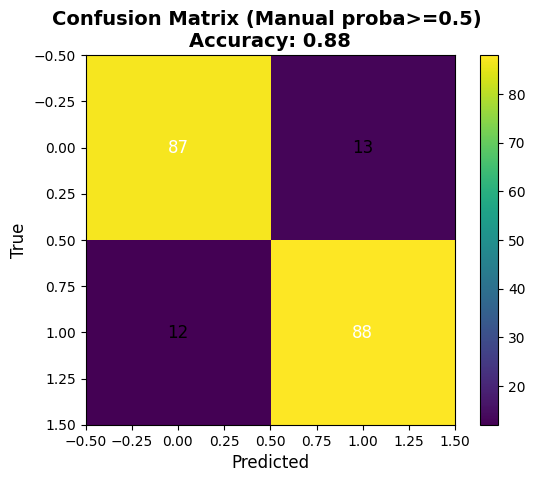

In [ ]:
###############################################################################
# 9) FINAL EVALUATION USING MANUAL PROBABILITY THRESHOLD = 0.5
###############################################################################
# Purpose: To use predict_proba() with a manual threshold for consistent classification.
proba_test = best_svm.predict_proba(X_test)  # shape: (num_samples, 2)
mal_prob = proba_test[:, 1]                   # probability for class "Malicious"
y_pred_manual = (mal_prob >= 0.5).astype(int)

acc_manual = accuracy_score(y_test, y_pred_manual)
print(f"[INFO] Final Accuracy (manual threshold=0.5): {acc_manual:.4f}")
print("[INFO] Classification Report (manual threshold=0.5):")
print(classification_report(y_test, y_pred_manual, target_names=["Benign","Malicious"]))

# Plot confusion matrix for manual threshold classification
cm_manual = confusion_matrix(y_test, y_pred_manual)
plt.figure()
plt.imshow(cm_manual, cmap='viridis')
plt.title(f"Confusion Matrix (Manual proba>=0.5) \nAccuracy: {acc_manual:.2f}", fontsize=14, fontweight='bold')
plt.colorbar()
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
for i in range(cm_manual.shape[0]):
    for j in range(cm_manual.shape[1]):
        plt.text(j, i, cm_manual[i,j], ha='center', va='center', color='white' if cm_manual[i,j]>cm_manual.max()/2 else 'black', fontsize=12)
plt.show()

In [ ]:
###############################################################################
# 10) LIME EXPLAINER SETUP
###############################################################################
# Purpose: To allow local, interpretable explanations for the SVM predictions.
from lime import lime_tabular

feature_names = [f"VisualWord_{i}" for i in range(NUM_CLUSTERS)] + ["Morph_1", "Morph_2"]

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    training_labels=y_train,
    feature_names=feature_names,
    class_names=["Benign", "Malicious"],
    mode="classification",
    discretize_continuous=True,  # Helps with explanation clarity
    verbose=True
)

print("[DEBUG] Enhanced LIME explainer is ready.")


[DEBUG] Enhanced LIME explainer is ready.


In [ ]:
###############################################################################
# 11) FORENSIC REPORT GENERATOR (USER FRIENDLY)
###############################################################################
def generate_forensic_report(index):
    sample_vec = X_test[index]
    true_label = y_test[index]
    fname = test_files[index]

    # Ensure shape for predict_proba
    if sample_vec.ndim == 1:
        sample_vec = sample_vec.reshape(1, -1)

    # Predict using best SVM
    proba = best_svm.predict_proba(sample_vec)[0]
    prob_ben, prob_mal = proba[0], proba[1]
    pred_label = 1 if prob_mal >= 0.5 else 0
    risk_score = prob_mal * 100

    print("\n========== FORENSIC REPORT ==========")
    print(f"File: {fname}")
    print(f"True Label:      {'Malicious' if true_label == 1 else 'Benign'}")
    print(f"Predicted Label: {'Malicious' if pred_label == 1 else 'Benign'}")
    print(f"Probability → Benign: {prob_ben:.4f} | Malicious: {prob_mal:.4f}")
    print(f"Risk Score (Malicious Confidence): {risk_score:.1f}/100")

    # Display QR image
    raw_img = next((img for img, lbl, file in all_data if file == fname), None)
    if raw_img is not None:
        plt.figure(figsize=(5, 5))
        plt.imshow(raw_img, cmap='gray')
        plt.title(f"QR Code: {fname}", fontsize=14)
        plt.axis('off')
        plt.show()

    # Risk Meter
    plt.figure(figsize=(6, 1.8))
    plt.barh(["Malicious Risk"], [risk_score], color='crimson' if risk_score >= 50 else 'forestgreen')
    plt.xlim([0, 100])
    plt.xlabel("Confidence (%)")
    plt.title("Malicious Probability")
    plt.tight_layout()
    plt.show()

    # LIME Explanation
    explanation = lime_explainer.explain_instance(
        data_row=X_test[index],
        predict_fn=best_svm.predict_proba,
        num_features=10
    )
    exp_list = explanation.as_list()
    print("\n[LIME Explanation - Top Features]:")
    for feat, weight in exp_list:
        impact = "↑" if weight > 0 else "↓"
        print(f"  {feat}: {weight:+.4f} ({impact} towards {'Malicious' if weight > 0 else 'Benign'})")

    # LIME Bar Chart
    feat_names = [f for f, _ in exp_list]
    feat_weights = [w for _, w in exp_list]
    colors = ['crimson' if w > 0 else 'skyblue' for w in feat_weights]

    plt.figure(figsize=(8, 4))
    y_pos = np.arange(len(feat_names))
    plt.barh(y_pos, feat_weights, color=colors)
    plt.yticks(y_pos, feat_names)
    plt.gca().invert_yaxis()
    plt.title("LIME: Top Contributing Features", fontsize=13, fontweight='bold')
    plt.xlabel("Feature Impact (Weight)", fontsize=11)
    plt.tight_layout()
    plt.show()

    print("========== END OF REPORT ==========\n")


In [ ]:
def pick_qr_for_report():
    """
    Allows the user to select a test sample index to generate a forensic report.
    """
    max_index = len(X_test) - 1
    print(f"[INFO] Please select an index between 0 and {max_index} for a forensic report.")
    while True:
        user_in = input(f"Enter an index (0-{max_index}) or 'q' to quit: ").strip()
        if user_in.lower() == 'q':
            print("[INFO] Exiting forensic report generator.")
            break
        if not user_in.isdigit():
            print("[ERROR] Invalid input. Please enter a valid integer or 'q'.")
            continue
        idx = int(user_in)
        if 0 <= idx <= max_index:
            generate_forensic_report(idx)
        else:
            print("[ERROR] Index out of range.")

[INFO] Please select an index between 0 and 199 for a forensic report.
Enter an index (0-199) or 'q' to quit: 125

========== FORENSIC REPORT ==========
File: qr_378_benign_images.png
True Label:      Benign
Predicted Label: Benign
Probability → Benign: 0.9030 | Malicious: 0.0970
Risk Score (Malicious Confidence): 9.7/100


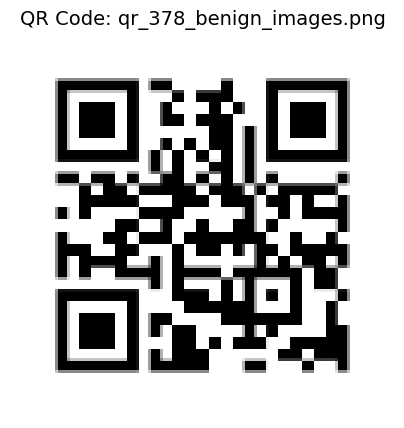

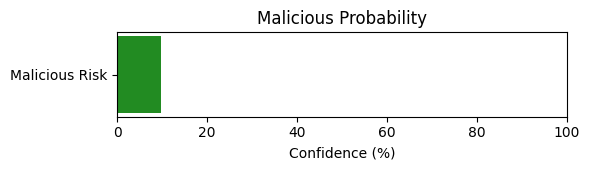

Intercept 0.6784398078436825
Prediction_local [0.24210314]
Right: 0.0969588051310174

[LIME Explanation - Top Features]:
  VisualWord_72 > 0.13: -0.1040 (↓ towards Benign)
  VisualWord_68 > 0.09: -0.0885 (↓ towards Benign)
  VisualWord_43 > 0.11: -0.0804 (↓ towards Benign)
  VisualWord_25 > 0.19: -0.0623 (↓ towards Benign)
  VisualWord_10 <= 0.00: -0.0532 (↓ towards Benign)
  VisualWord_28 <= 0.04: -0.0528 (↓ towards Benign)
  VisualWord_24 <= 0.16: +0.0461 (↑ towards Malicious)
  VisualWord_5 <= 0.03: -0.0434 (↓ towards Benign)
  VisualWord_0 > 0.11: +0.0429 (↑ towards Malicious)
  VisualWord_30 <= 0.09: -0.0406 (↓ towards Benign)


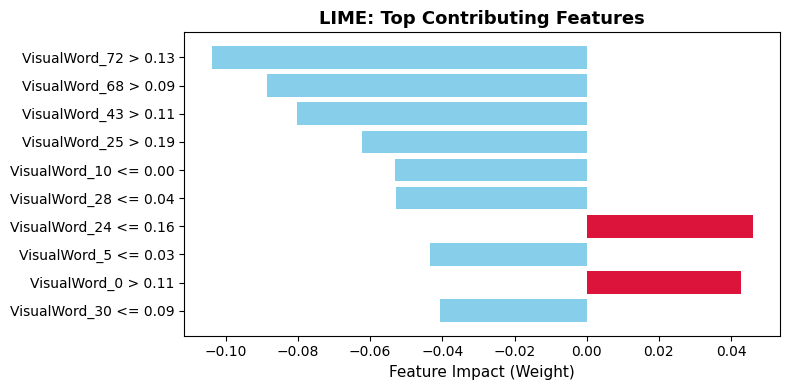

========== END OF REPORT ==========

Enter an index (0-199) or 'q' to quit: 200
[ERROR] Index out of range.
Enter an index (0-199) or 'q' to quit: 199

========== FORENSIC REPORT ==========
File: qr_327_malicious_images.png
True Label:      Malicious
Predicted Label: Malicious
Probability → Benign: 0.1811 | Malicious: 0.8189
Risk Score (Malicious Confidence): 81.9/100


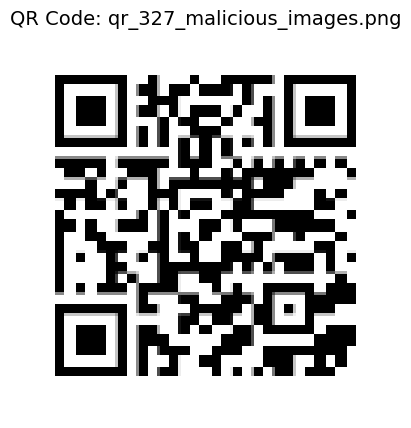

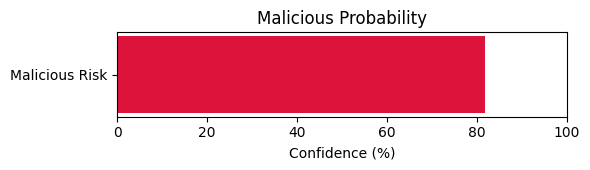

Intercept 0.5185106821747544
Prediction_local [0.62950972]
Right: 0.8189390916757676

[LIME Explanation - Top Features]:
  VisualWord_56 > 0.14: -0.0837 (↓ towards Benign)
  VisualWord_21 <= 0.00: +0.0658 (↑ towards Malicious)
  VisualWord_10 > 0.09: +0.0586 (↑ towards Malicious)
  VisualWord_97 <= 0.06: +0.0581 (↑ towards Malicious)
  VisualWord_2 <= 0.11: -0.0549 (↓ towards Benign)
  VisualWord_61 > 0.09: +0.0529 (↑ towards Malicious)
  VisualWord_22 > 0.13: +0.0509 (↑ towards Malicious)
  VisualWord_43 <= 0.04: +0.0392 (↑ towards Malicious)
  VisualWord_76 <= 0.04: -0.0381 (↓ towards Benign)
  VisualWord_24 > 0.24: -0.0377 (↓ towards Benign)


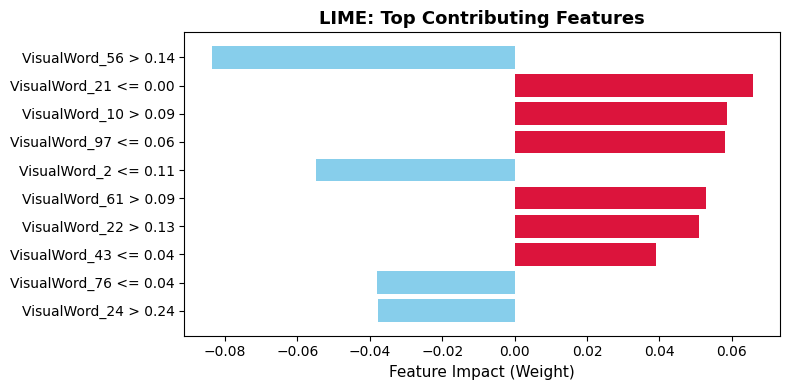

========== END OF REPORT ==========

Enter an index (0-199) or 'q' to quit: 34

========== FORENSIC REPORT ==========
File: qr_186_malicious_images.png
True Label:      Malicious
Predicted Label: Malicious
Probability → Benign: 0.0846 | Malicious: 0.9154
Risk Score (Malicious Confidence): 91.5/100


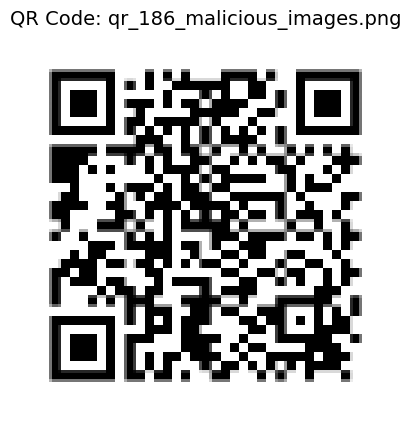

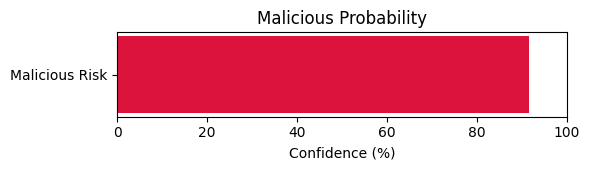

Intercept 0.4711259495993555
Prediction_local [0.77048253]
Right: 0.915427030946289

[LIME Explanation - Top Features]:
  VisualWord_72 <= 0.05: +0.0907 (↑ towards Malicious)
  VisualWord_68 <= 0.02: +0.0725 (↑ towards Malicious)
  VisualWord_21 <= 0.00: +0.0615 (↑ towards Malicious)
  VisualWord_28 > 0.09: +0.0594 (↑ towards Malicious)
  VisualWord_27 > 0.12: +0.0594 (↑ towards Malicious)
  VisualWord_31 > 0.17: +0.0581 (↑ towards Malicious)
  VisualWord_41 <= 0.08: -0.0574 (↓ towards Benign)
  VisualWord_22 > 0.13: +0.0495 (↑ towards Malicious)
  VisualWord_2 <= 0.11: -0.0474 (↓ towards Benign)
  VisualWord_45 <= 0.05: -0.0471 (↓ towards Benign)


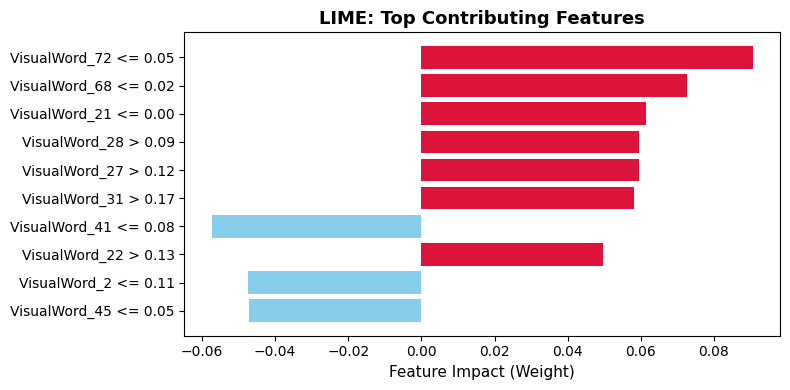

========== END OF REPORT ==========

Enter an index (0-199) or 'q' to quit: q
[INFO] Exiting forensic report generator.


In [ ]:
pick_qr_for_report()